<a href="https://colab.research.google.com/github/felixkoerber/Multimodal-Integration-ABIDE/blob/main/Multimodal_Integration_for_Indentifying_Stratification_of_ASD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
train=False
yang =True

# Multimodal Integration for Indentifying Stratification of ASD

Code for Bachelor Thesis of Felix Körber

# Imports

In [ ]:
## Torch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.data
from torch import nn,optim
from torch.autograd import Variable

try:
  from ignite.engine import Engine, Events
  from ignite.handlers import EarlyStopping
except:
  !pip install pytorch-ignite
  from ignite.engine import Engine, Events
  from ignite.handlers import EarlyStopping

## Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import seaborn as sns
!pip install graphviz
!pip install torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
!pip install statannotations
from statannotations.Annotator import Annotator

# Data Handling
import numpy as np
import pandas as pd

#scikit
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from yellowbrick.style import set_palette

#sklearn
from sklearn.metrics.cluster import rand_score
from sklearn.neighbors import KDTree
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Import tableone
try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne, load_dataset

#scipy
from scipy import spatial
from scipy import stats
from scipy.stats import kendalltau, pearsonr, permutation_test,bootstrap, norm

#nilearn
!pip install nilearn
import nilearn
from nilearn import datasets
from nilearn import plotting


import warnings

import plotly.graph_objects as go
from operator import ifloordiv

# Misc

import cv2
from PIL import Image
import os
import sys
import imageio

import argparse
# Link Google Drive
from google.colab import drive
drive.mount('/content/drive/')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 32.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive/


Set Up GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model Architecture

In [ ]:
#@title

# adapted from pytorch/examples/vae and ethanluoyc/pytorch-vae


class FC_VAE(nn.Module):
    """Fully connected variational Autoencoder"""
    def __init__(self, n_input, nz, n_hidden=1024):
        super(FC_VAE, self).__init__()
        self.nz = nz
        self.n_input = n_input
        self.n_hidden = n_hidden

        self.encoder = nn.Sequential(nn.Linear(n_input, n_hidden*5),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(n_hidden*5),

                                nn.Linear(n_hidden*5, n_hidden*2),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(n_hidden*2),

                                nn.Linear(n_hidden*2, n_hidden),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(n_hidden),

                                nn.Linear(n_hidden, n_hidden),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(n_hidden),

                                nn.Linear(n_hidden, n_hidden),
                                nn.ReLU(inplace=True),
                                nn.BatchNorm1d(n_hidden),
                                nn.Linear(n_hidden, n_hidden),
                                )

        self.fc1 = nn.Linear(n_hidden, nz)
        self.fc2 = nn.Linear(n_hidden, nz)

        self.decoder = nn.Sequential(nn.Linear(nz, n_hidden),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(n_hidden),

                                     nn.Linear(n_hidden, n_hidden),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(n_hidden),

                                     nn.Linear(n_hidden, n_hidden),
                                     nn.BatchNorm1d(n_hidden),
                                     nn.ReLU(inplace=True),


                                     nn.Linear(n_hidden, n_hidden*2),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(n_hidden*2),

                                     nn.Linear(n_hidden*2, n_hidden*5),
                                     nn.ReLU(inplace=True),
                                     nn.BatchNorm1d(n_hidden*5),
                                     nn.Linear(n_hidden*5, n_input),
                                    )
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.fc1(h), self.fc2(h)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z

    def generate(self, z):
        res = self.decode(z)
        return res



class FC_Classifier(nn.Module):
    """Latent space discriminator"""
    def __init__(self, nz, n_hidden=512, n_out=3):
        super(FC_Classifier, self).__init__()
        self.nz = nz
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.net = nn.Sequential(
            nn.Linear(nz, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden,n_out)
        )
    def forward(self, x):
        return self.net(x)

class Simple_Classifier(nn.Module):
    """Latent space discriminator"""
    def __init__(self, nz, n_out=3):
        super(Simple_Classifier, self).__init__()
        self.nz = nz
        self.n_out = n_out

        self.net = nn.Sequential(
            nn.Linear(nz, n_out),
        )

    def forward(self, x):
        return self.net(x)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Arguments

In [ ]:
# parse arguments
class setup_args():

    batch_size=32
    max_epochs=300
    nz=512
    lamb=0.0000001 #beta weight
    alpha =.1
    dist_factor =1
    learning_rate_D = 1e-4
    learning_rate_AE =1e-4
    weight_decay=0
    n_hidden=512
    save_freq=10

args = setup_args()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Set-Up Data

In [ ]:
### Dataloader
class Combined_Dataset_Train():
    def __init__(self):
        isfunc=np.load("/content/drive/My Drive/BA/isfunc.npy", allow_pickle=True)
        #Pheno Data
        pheno_data=pd.read_csv('/content/drive/My Drive/BA/pheno_data.csv', index_col=0)
        pheno_data.iloc[isfunc==1]

        #Functional Data
        func_data= np.load("/content/drive/My Drive/BA/func_flat_Tal_new.npy", allow_pickle=True)
        func_data[np.where(np.isnan(func_data))]=0
        func_data= (func_data - np.mean(func_data)) / np.std(func_data)

        #Area Data
        area_data=np.load('/content/drive/My Drive/BA/area_data_red.npy')[:,:,0].T
        area_data=(area_data - np.mean(area_data)) / np.std(area_data)
        area_data=area_data[isfunc==1]
        #Cortical Thickness Data
        thick_data=np.load('/content/drive/My Drive/BA/thick_data_red.npy')[:,:,0].T
        thick_data=(thick_data - np.mean(thick_data)) / np.std(thick_data)
        thick_data=thick_data[isfunc==1]

        self.label = pheno_data.iloc             [isfunc==1]
        self.func_data = func_data              [:]
        self.area_data =area_data               [:]
        self.thick_data =thick_data             [:]

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return torch.tensor(self.func_data[idx,:]).float(),torch.tensor(self.area_data[idx,:]).float(),torch.tensor(self.thick_data[idx,:]).float(),torch.tensor(self.label.iloc[idx,6]-1)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Initiate Dataloader and Models

In [ ]:
# retrieve dataloader

# Define the train and test dataloaders
dataset_Train = (Combined_Dataset_Train())
train_dataloader = DataLoader(dataset_Train, batch_size=args.batch_size, drop_last=False, shuffle=True)

dataset_Test = (Combined_Dataset_Train())
test_dataloader = DataLoader(dataset_Test, batch_size=args.batch_size,drop_last=False, shuffle=False)

print('Data loaded')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data loaded


In [ ]:

#============= TRAINING INITIALIZATION ==============

# initialize autoencoder
model_func = FC_VAE  (n_input=4656,    nz=args.nz,n_hidden=args.n_hidden).to(device)
model_thick = FC_VAE (n_input=163842,  nz=args.nz,n_hidden=args.n_hidden).to(device)
model_area = FC_VAE  (n_input=163842,  nz=args.nz,n_hidden=args.n_hidden).to(device)
netClf = FC_Classifier(nz=args.nz).to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# setup optimizer

opt_netthick  = torch.optim.Adam(params=model_thick.parameters (), lr=args.learning_rate_AE)
opt_netarea   = torch.optim.Adam(params=model_area.parameters  (), lr=args.learning_rate_AE)
opt_netfunc   = torch.optim.Adam(params=model_func.parameters  (), lr=args.learning_rate_AE)
opt_netClf    = torch.optim.Adam(params=netClf.parameters      (), lr=args.learning_rate_D)

# loss criteria
criterion_reconstruct = nn.MSELoss()
criterion_classify    = nn.CrossEntropyLoss()
criterion_latent_dis  = nn.L1Loss()

criterion_reconstruct = criterion_reconstruct.to(device)
criterion_classify    = criterion_classify.to(device)
criterion_latent_dis    = criterion_latent_dis.to(device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training

In [ ]:
def compute_KL_loss(mu, logvar):
    if args.lamb>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return args.lamb * KLloss
    return 0

def train_autoencoders(func_inputs, area_inputs, thick_inputs,labels):
    model_thick.train()
    model_area.train()
    model_func.train()
    netClf.eval()

    if torch.cuda.is_available():
      thick_inputs, area_inputs,func_inputs = thick_inputs.to(device), area_inputs.to(device),func_inputs.to(device)
      labels=labels.to(device)

    # forward pass
    thick_recon, thick_latents,thick_mu, thick_logvar = model_thick(thick_inputs)
    area_recon, area_latents, area_mu, area_logvar = model_area(area_inputs)
    func_recon, func_latents,func_mu, func_logvar = model_func(func_inputs)

    thick_to_area=model_area.decode(thick_latents)
    thick_to_func=model_func.decode(thick_latents)

    area_to_thick=model_thick.decode(area_latents)
    area_to_func=model_func.decode(area_latents)

    func_to_thick=model_thick.decode(func_latents)
    func_to_area=model_area.decode(area_latents)

    thick_scores = netClf(thick_latents)
    area_scores = netClf(area_latents)
    func_scores = netClf(func_latents)


    thick_labels = torch.zeros  (thick_scores.size(0),).long()
    area_labels  = torch.zeros(area_scores.size (0),).long()
    func_labels  = torch.zeros (func_scores.size(0),).long()

    thick_labels[:]= 0
    area_labels [:]= 1
    func_labels [:]= 2

    if torch.cuda.is_available():
        thick_labels, area_labels,func_labels = thick_labels.to(device), area_labels.to(device),func_labels.to(device)


    # compute recon losses
    thick_recon_loss = criterion_reconstruct(thick_inputs, thick_recon)
    area_recon_loss = criterion_reconstruct(area_inputs, area_recon)
    func_recon_loss = criterion_reconstruct(func_inputs, func_recon)


    distances_metric =  (1/3)*criterion_latent_dis(func_latents,thick_latents) +   (1/3)*criterion_latent_dis(func_latents,area_latents)+(1/3)*criterion_latent_dis(thick_latents,area_latents)
    distances_metric = args.dist_factor*distances_metric

    # compute cross modal latent recon losses
    cmrl_ttoa= criterion_reconstruct(area_inputs, thick_to_area)
    cmrl_ttof= criterion_reconstruct(func_inputs, thick_to_func)

    cmrl_atot= criterion_reconstruct(thick_inputs, area_to_thick)
    cmrl_atof= criterion_reconstruct(func_inputs, area_to_func)

    cmrl_ftot= criterion_reconstruct(thick_inputs, func_to_thick)
    cmrl_ftoa= criterion_reconstruct(area_inputs, func_to_area)

    cmrl = (cmrl_ttoa+cmrl_ttof+cmrl_atot+cmrl_atof+cmrl_ftot+cmrl_ftoa)/6

    # compute crossmodal loss

    kl_loss = compute_KL_loss(thick_mu, thick_logvar) + compute_KL_loss(area_mu, area_logvar)+compute_KL_loss(func_mu,func_logvar)
    clf_loss =  (1/6) * criterion_classify(thick_scores, area_labels) +  \
      (1/6) * criterion_classify(thick_scores, func_labels) +(1/6) * criterion_classify(area_scores, func_labels) + \
      (1/6)* criterion_classify(area_scores, thick_labels) +  (1/6) * criterion_classify(func_scores, area_labels) +  (1/6) * criterion_classify(func_scores, thick_labels)
    #clf_loss = (1/3)*criterion_classify(thick_scores, thick_labels) + (1/3)* criterion_classify(area_scores, area_labels) + (1/3)* criterion_classify(func_scores, func_labels)
    loss = thick_recon_loss + area_recon_loss + func_recon_loss+ kl_loss   +  clf_loss +distances_metric + cmrl


    # reset parameter gradients
    opt_netthick.zero_grad()
    opt_netarea.zero_grad()
    opt_netfunc.zero_grad()

    # backpropagate and update model
    loss.backward()

    opt_netthick.step()
    opt_netarea.step()
    opt_netfunc.step()

    #Validation Loss
    summary_stats = {'loss': loss,'thick_recon_loss': thick_recon_loss*thick_scores.size(0), 'area_recon_loss': area_recon_loss*area_scores.size(0),
                     'func_recon_loss': func_recon_loss*func_scores.size(0),'clf_loss': clf_loss*(thick_scores.size(0)+area_scores.size(0)+func_scores.size(0)),
                      'cmr_loss':cmrl*(thick_scores.size(0)+area_scores.size(0)+func_scores.size(0)),
                      'KL_loss':kl_loss,'distances_metric':distances_metric*(thick_scores.size(0)+area_scores.size(0)+func_scores.size(0))
                      }

    return summary_stats

def train_classifier(func_inputs,area_inputs,thick_inputs):

    model_thick.eval()
    model_area.eval()
    model_func.eval()
    netClf.train()

    # process input data
    if torch.cuda.is_available():
      thick_inputs, area_inputs,func_inputs = thick_inputs.to(device), area_inputs.to(device),func_inputs.to(device)


    # forward pass
    _, thick_latents, _, _  = model_thick(thick_inputs)
    _, area_latents, _, _   = model_area(area_inputs)
    _, func_latents, _, _   = model_func(func_inputs)

    thick_scores  = netClf(thick_latents)
    area_scores   = netClf(area_latents)
    func_scores   = netClf(func_latents)

    thick_labels = torch.zeros  (thick_scores.size(0),).long()
    area_labels  = torch.zeros(area_scores.size (0),).long()
    func_labels  = torch.zeros (func_scores.size(0),).long()

    thick_labels[:]= 0
    area_labels [:]= 1
    func_labels [:]= 2

    if torch.cuda.is_available():
        thick_labels, area_labels,func_labels = thick_labels.to(device), area_labels.to(device),func_labels.to(device)

    clf_loss = (1/3)*criterion_classify(thick_scores, thick_labels) + (1/3)* criterion_classify(area_scores, area_labels) + (1/3)* criterion_classify(func_scores, func_labels)
    loss = clf_loss


    # backpropagate and update model
    opt_netClf.zero_grad()
    loss.backward()
    opt_netClf.step()
    summary_stats = {'clf_loss': clf_loss*(thick_scores.size(0)+area_scores.size(0)+area_scores.size(0)),
                     'thick_n_samples': thick_scores.size(0),'area_n_samples': area_scores.size(0),
                     'func_n_samples':func_scores.size(0)}

    return summary_stats

def accuracy(output, target):
    c=output.cpu().detach().numpy()
    target=target.cpu().detach().numpy()
    c[np.where(c>0.5)]=1
    c[np.where(c<0.5)]=0
    list=0
    for i,j in zip(c,target):
      if i==j:
        list+=1
    acc=list/len(target)
    #print(acc, list)
    return(acc)


def mean_loss(input):
  mean=criterion_reconstruct(input,torch.mean(input))
  return mean

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
mean_func        = 0
mean_thick       = 0
mean_area        = 0
for idx, (sample) in enumerate(train_dataloader):

  func_inputs   = sample[0]
  area_inputs   = sample[1]
  thick_inputs  = sample[2]
  labels        = sample[3]
  print(func_inputs.shape,area_inputs.shape,thick_inputs.shape,labels.shape)
  mean_func     +=mean_loss(func_inputs)
  mean_area     +=mean_loss(area_inputs)
  mean_thick    +=mean_loss(thick_inputs)
mean_func /= 883
mean_area /= 883
mean_thick/= 883


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 4656])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 163842])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.m

torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size([32, 4656]) torch.Size([32, 163842]) torch.Size([32, 163842]) torch.Size([32])
torch.Size

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([19, 4656])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([19, 163842])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
if train ==True:
  print('Training Model')
  combined_loss=torch.empty(size=(0,11))

  for epoch in range(args.max_epochs):
      #print(epoch)

      recon_thick_loss = 0
      recon_area_loss  = 0
      recon_func_loss  = 0
      KL_loss          = 0
      clf_loss         = 0
      AE_clf_loss      = 0
      cmr_loss         = 0
      distances_metric = 0
      n_thick_total    = 0
      n_area_total     = 0
      n_func_total     = 0
      total_loss       = 0

      for idx, (sample) in enumerate(train_dataloader):
          func_inputs   = sample[0]
          area_inputs   = sample[1]
          thick_inputs  = sample[2]
          labels        = sample[3]

          out = train_autoencoders(func_inputs, area_inputs, thick_inputs,labels)

          recon_thick_loss += out['thick_recon_loss']
          recon_area_loss += out['area_recon_loss']
          recon_func_loss += out['func_recon_loss']
          AE_clf_loss += out['clf_loss']
          cmr_loss    += out['cmr_loss']
          KL_loss     += out['KL_loss']
          distances_metric  += out['distances_metric']
          total_loss  += out['loss']
          out = train_classifier(func_inputs, area_inputs,thick_inputs)

          clf_loss      += out['clf_loss']
          n_thick_total += out['thick_n_samples']
          n_area_total  += out['area_n_samples']
          n_func_total += out['func_n_samples']



      recon_thick_loss  /= n_thick_total
      recon_area_loss   /= n_area_total
      recon_func_loss   /= n_func_total
      cmr_loss          /= (n_thick_total+n_area_total+n_func_total)
      distances_metric  /= ((n_thick_total+n_area_total+n_func_total)*args.dist_factor)
      KL_loss           /= (n_thick_total+n_area_total+n_func_total)
      clf_loss /= (n_thick_total+n_area_total+n_func_total)
      AE_clf_loss /= (n_thick_total+n_area_total+n_func_total)

      if epoch==0:
        combined_loss=torch.tensor([recon_thick_loss,mean_thick,recon_area_loss,mean_area,recon_func_loss,mean_func,KL_loss,AE_clf_loss,cmr_loss,AE_clf_loss,clf_loss,distances_metric,total_loss])[None,:]
        print(combined_loss.size())
      else:
        combined_loss=torch.cat((combined_loss,torch.tensor([recon_thick_loss,mean_thick,recon_area_loss,mean_area,recon_func_loss,mean_func,KL_loss,AE_clf_loss,cmr_loss,AE_clf_loss,clf_loss,distances_metric,total_loss])[None,:]))
        if epoch==1:
          print(combined_loss.size())
      print('Epoch: ', epoch ,'total loss: ',total_loss,  'distance metric: %.8f' % float(distances_metric), ', thick recon loss: %.8f' % float(recon_thick_loss), ', area recon loss: %.8f' % float(recon_area_loss), ', func recon loss: %.8f' % float(recon_func_loss),
                  ', KL Div. loss: %.8f' %float (KL_loss), ', Cross-Modal loss: %.8f' % float(cmr_loss), ', AE clf loss: %.8f' % float(AE_clf_loss), ', clf loss: %.8f' % float(clf_loss))
      print('Meanthick: ',mean_thick,'Mean area: ',mean_area,'Mean func: ',mean_func)
  for idx in range(len(combined_loss)):
    if idx<7:
      plt.plot(combined_loss[:,idx])
      #print(combined_loss[:,idx])

  '''torch.save(model_thick.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/",  "big_model_thick_complicated_loss_%s.pth" % epoch))
  torch.save  (model_area.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/", "big_model_area_complicated_loss_%s.pth" % epoch))
  torch.save  (model_func.cpu().state_dict(), os.path.join("/content/drive/My Drive/BA/weights/","big_model_func_complicated_loss_%s.pth" % epoch))
  torch.save  (netClf.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/",     "big_netClf_complicated_loss_%s.pth" % epoch))'''
  for idx in range(len(combined_loss)):
    if idx<12:
      plt.plot(combined_loss[:,idx])
      #print(combined_loss[:,idx])
else:
  print('Training skipped due to User Input, using saved loads instead')
  model_thick.load_state_dict(torch.load(os.path.join      ("/content/drive/My Drive/BA/weights/bohe_model_thick_complicated_loss_299.pth")))
  model_area.load_state_dict(torch.load(os.path.join       ("/content/drive/My Drive/BA/weights/bohe_model_area_complicated_loss_299.pth")))
  model_func.load_state_dict(torch.load(os.path.join       ("/content/drive/My Drive/BA/weights/bohe_model_func_complicated_loss_299.pth")))
  netClf.load_state_dict(torch.load(os.path.join           ("/content/drive/My Drive/BA/weights/bohe_netClf_complicated_loss_299.pth")))
  print("Weights Loaded")


Training skipped due to User Input, using saved loads instead


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Weights Loaded


## Yang integration

In [ ]:
def nearest_neighbour(points_a, points_b):
      tree = spatial.KDTree(points_b)
      return tree.query(points_a,k=50)[1]

if yang == True:
  # initialize autoencoder
  yang_model_func    = FC_VAE  (n_input=4656,    nz=args.nz,n_hidden=args.n_hidden).to(device)
  yang_model_thick  = FC_VAE (n_input=163842,  nz=args.nz,n_hidden=args.n_hidden).to(device)
  yang_model_area   = FC_VAE  (n_input=163842,  nz=args.nz,n_hidden=args.n_hidden).to(device)
  yang_netClf        = FC_Classifier(nz=args.nz).to(device)
  yang_model_func   .load_state_dict(torch.load(os.path.join      ("/content/drive/My Drive/BA/weights/yang_bohe_model_func_complicated_loss_308.pth")))
  yang_model_thick .load_state_dict(torch.load(os.path.join      ("/content/drive/My Drive/BA/weights/yang_bohe_model_thick_complicated_loss_308.pth")))
  yang_model_area  .load_state_dict(torch.load(os.path.join      ("/content/drive/My Drive/BA/weights/yang_bohe_model_area_complicated_loss_308.pth")))
  yang_netClf      .load_state_dict(torch.load(os.path.join      ("/content/drive/My Drive/BA/weights/yang_bohe_netClf_complicated_loss_308.pth")))
  yang_model_func.to(device)
  yang_model_thick.to(device)
  yang_model_area.to(device)

  for idx, (sample) in enumerate(test_dataloader):
      func_inputs   = sample[0]
      area_inputs   = sample[1]
      thick_inputs  = sample[2]
      labels        = sample[3]

      if torch.cuda.is_available():
          thick_inputs, area_inputs,func_inputs = thick_inputs.cuda(), area_inputs.cuda(), func_inputs.cuda()

      # forward pass
      _, thick_latents, _, _ =  yang_model_thick  (thick_inputs)
      _, area_latents, _, _ =   yang_model_area (area_inputs)
      _, func_latents, _, _ =   yang_model_func (func_inputs)

      if idx ==0:
        yang_thick_latent_ful,yang_area_latent_ful,yang_func_latent_ful=thick_latents,area_latents,func_latents

      else:
        yang_thick_latent_ful=torch.cat((yang_thick_latent_ful,thick_latents))
        yang_area_latent_ful=torch.cat((yang_area_latent_ful,area_latents))
        yang_func_latent_ful=torch.cat((yang_func_latent_ful,func_latents))
  n=0
  yang_neighbors = np.zeros((6,yang_func_latent_ful.size(0),50))
  for i, lat_vec1 in enumerate([yang_area_latent_ful.detach().numpy(), yang_thick_latent_ful.detach().numpy(), yang_func_latent_ful.detach().numpy()]):
    for j, lat_vec2 in enumerate([yang_area_latent_ful.detach().numpy(), yang_thick_latent_ful.detach().numpy(), yang_func_latent_ful.detach().numpy()]):
      if i!=j:
        yang_neighbors[n,:]=nearest_neighbour(lat_vec1,lat_vec2)
        n+=1
  yang_neighbors_acc = np.zeros((7,50))
  for m in range(6):
    for k in range(50):
      acc=0
      for i in range(yang_func_latent_ful.size(0)):
        if i in yang_neighbors[m,i,:k]:
          acc+=1
      if k==0:
        yang_neighbors_acc[m,k]=0
      else:
        yang_neighbors_acc[m,k]=acc/yang_func_latent_ful.size(0)
  for k in range(50):
    if k==0:
      yang_neighbors_acc[6,k]=0
    else:
      yang_neighbors_acc[6,k]=1/(yang_func_latent_ful.size(0)/k)

  yang_neighbors_acc = pd.DataFrame(yang_neighbors_acc.T, columns = ['Goal: FC, Neighbors: CSA',
                                                'Goal: FC, Neighbors: CT',
                                                'Goal: CSA, Neighbors: FC',
                                                'Goal: CSA, Neighbors: CT',
                                                'Goal: CT, Neighbors: FC',
                                                'Goal: CT, Neighbors: CSA',
                                                'Random Accuracy'])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
thick_labels = torch.zeros  (yang_thick_latent_ful.shape[0]).long()
area_labels  = torch.zeros(yang_thick_latent_ful.shape[0]).long()
func_labels  = torch.zeros (yang_thick_latent_ful.shape[0]).long()

thick_labels[:]= 0
area_labels [:]= 1
func_labels [:]= 2
for i,m in enumerate((thick_latent_ful,area_latent_ful,area_latent_ful)):


print(criterion_classify(yang_netClf(yang_thick_latent_ful),thick_labels),
      criterion_classify(yang_netClf(yang_area_latent_ful),area_labels),
      criterion_classify(yang_netClf(yang_func_latent_ful),func_labels))
print(criterion_classify(netClf(thick_latent_ful),thick_labels),
      criterion_classify(netClf(area_latent_ful),area_labels),
      criterion_classify(netClf(func_latent_ful),func_labels))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndentationError: ignored

In [ ]:
'''torch.save(model_thick.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/",  "bohe_model_thick_complicated_loss_%s.pth" % epoch))
torch.save  (model_area.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/", "bohe_model_area_complicated_loss_%s.pth" % epoch))
torch.save  (model_func.cpu().state_dict(), os.path.join("/content/drive/My Drive/BA/weights/","bohe_model_func_complicated_loss_%s.pth" % epoch))
torch.save  (netClf.cpu().state_dict(),os.path.join("/content/drive/My Drive/BA/weights/",     "bohe_netClf_complicated_loss_%s.pth" % epoch))'''

# Clusteranalysis

In [ ]:
#import full pheno
pheno2=pd.read_csv('/content/drive/My Drive/BA/pheno_relevant.csv', index_col=0)
#str labels to int
pheno2['HANDEDNESS_CATEGORY'].loc[pheno2['HANDEDNESS_CATEGORY']=='R']=0
pheno2['HANDEDNESS_CATEGORY'].loc[pheno2['HANDEDNESS_CATEGORY']=='L']=1
pheno2['HANDEDNESS_CATEGORY'].loc[pheno2['HANDEDNESS_CATEGORY']=='Mixed']=2
pheno2['HANDEDNESS_CATEGORY'].loc[pheno2['HANDEDNESS_CATEGORY']=='Ambi']=2
pheno2['HANDEDNESS_CATEGORY'].loc[pheno2['HANDEDNESS_CATEGORY']=='L->R']=2


pheno2= pheno2.drop(['HANDEDNESS_SCORES','ADI_R_RSRCH_RELIABLE','ADOS_MODULE','SRS_AWARENESS','SRS_COGNITION','SRS_COMMUNICATION','SRS_MOTIVATION','SRS_MANNERISMS','SRS_MANNERISMS','SCQ_TOTAL','AQ_TOTAL'],axis=1)
cluster=list(pheno2.columns)
mytable = TableOne(pheno2,cluster, dip_test=True, normal_test=True, tukey_test=True)


#impute missing labels for KMeans
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(pheno2)
pheno2_imputed=imp.transform(pheno2)

#Get internal clustering
# Elbow Method for K means# Import ElbowVisualizer

model = KMeans()
# k is range of number of clusters.
visualizer_pheno = KElbowVisualizer(model, k=(2,10 ), timings= True,n_init=10)
visualizer_pheno.fit(pheno2_imputed)        # Fit data to visualizer
visualizer_pheno.show()

In [ ]:
#courtesy of https://stackoverflow.com/questions/35611465/python-scikit-learn-clustering-with-missing-data
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.
    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.
    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much faster and makes it easier to check convergence (since labels won't be permuted on every iteration), but might be more prone togetting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [ ]:
model_thick.to(device)
model_area.to(device)
model_func.to(device)
netClf.to(device)
for idx, (sample) in enumerate(test_dataloader):
    func_inputs   = sample[0]
    area_inputs   = sample[1]
    thick_inputs  = sample[2]
    labels        = sample[3]

    if torch.cuda.is_available():
        thick_inputs, area_inputs,func_inputs = thick_inputs.cuda(), area_inputs.cuda(), func_inputs.cuda()

    # forward pass
    _, thick_latents, _, _ = model_thick(thick_inputs)
    _, area_latents, _, _ = model_area(area_inputs)
    _, func_latents, _, _ = model_func(func_inputs)

    thick_scores = netClf(thick_latents)
    area_scores = netClf(area_latents)

    func_scores = netClf(func_latents)
    if idx ==0:
      thick_latent_ful,area_latent_ful,func_latent_ful,labels_ful=thick_latents,area_latents,func_latents,labels

    else:
      thick_latent_ful=torch.cat((thick_latent_ful,thick_latents))
      area_latent_ful=torch.cat((area_latent_ful,area_latents))
      func_latent_ful=torch.cat((func_latent_ful,func_latents))
      labels_ful=torch.cat((labels_ful,labels))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def nearest_neighbour(points_a, points_b):
    tree = spatial.KDTree(points_b)
    return tree.query(points_a,k=50)[1]
n=0
neighbors = np.zeros((6,func_latent_ful.size(0),50))
for i, lat_vec1 in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
  for j, lat_vec2 in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
    if i!=j:
      neighbors[n,:]=nearest_neighbour(lat_vec1,lat_vec2)
      n+=1

neighbors_acc = np.zeros((7,50))

for m in range(6):
  for k in range(50):
    acc=0
    for i in range(func_latent_ful.size(0)):
      if i in neighbors[m,i,:k]:
        acc+=1
    if k==0:
      neighbors_acc[m,k]=0
    else:
      neighbors_acc[m,k]=acc/func_latent_ful.size(0)
for k in range(50):
  if k==0:
    neighbors_acc[6,k]=0
  else:
    neighbors_acc[6,k]=1/(func_latent_ful.size(0)/k)

neighbors_acc = pd.DataFrame(neighbors_acc.T, columns = ['Goal: FC, Neighbors: CSA',
                                              'Goal: FC, Neighbors: CT',
                                              'Goal: CSA, Neighbors: FC',
                                              'Goal: CSA, Neighbors: CT',
                                              'Goal: CT, Neighbors: FC',
                                              'Goal: CT, Neighbors: CSA',
                                              'Random Accuracy'])



In [ ]:
'''np.save("/content/drive/My Drive/BA/bh_func_latents",func_latent_ful.detach().cpu().numpy())
np.save("/content/drive/My Drive/BA/bh_area_latents",thick_latent_ful.detach().cpu().numpy())
np.save("/content/drive/My Drive/BA/bh_thick_latents",area_latent_ful.detach().cpu().numpy())'''

In [ ]:

fig, ax = plt.subplots(1,2,figsize=(10,4), dpi=300, constrained_layout=True)

ax1 = sns.lineplot(data=neighbors_acc,ax=ax[0],legend=None)
ax1.set(ylim=(0, 1))
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax1.legend()

ax1.set(xlabel="Number of k-nearest neighbors", ylabel="k-nearest neighbors accuracy")
ax1.set_title("Our Method")
ax2 = sns.lineplot(data=yang_neighbors_acc,ax=ax[1])
ax2.set(ylim=(0, 1))

box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax2.legend(loc='upper center', bbox_to_anchor=(-0.15, -0.15),
          fancybox=True, shadow=True, ncol=2,frameon=True)
ax2.set_title("Yang et al. (2021)")

ax2.set(xlabel="Number of k-nearest neighbors", ylabel="k-nearest neighbors accuracy")

#plt.suptitle("k-nearest Neighbor Accuracy of different Modality Pairs")



In [ ]:
warnings.filterwarnings("ignore")
model = KMeans()
set_palette('paired')
fig, ax = plt.subplots(1,3,figsize=(10,3), dpi=300, constrained_layout=True)

fig.suptitle("Distortion Score Elbow for KMeans Clusterings")

visualizer_func = KElbowVisualizer(model, k=(2,10 ), timings= False,n_init=10,ax=ax[0],vline_color="red")
visualizer_func.fit(func_latent_ful.detach().cpu().numpy())        # Fit data to visualizer

ax[0].set(xlabel='k', ylabel='Distortion Score', title='Functional Connectivity', xticks=range(2,10))


visualizer_area = KElbowVisualizer(model, k=(2,10 ), timings= False,n_init=10,ax=ax[1], metric_color='C1')
visualizer_area.fit(area_latent_ful.detach().cpu().numpy())        # Fit data to visualizer
ax[1].set(xlabel='k', ylabel='Distortion Score', title='Cortical Surface Area', xticks=range(2,10))

visualizer_thick = KElbowVisualizer(model, k=(2,10 ), timings= False,n_init=10,ax=ax[2], metric_color='C1')
visualizer_thick.fit(thick_latent_ful.detach().cpu().numpy())        # Fit data to visualizer
ax[2].set(xlabel='k', ylabel='Distortion Score', title='Cortical Thickness', xticks=range(2,10))

plt.show()

In [ ]:
kmeans_func = KMeans  (n_clusters=5, random_state=0).fit(func_latent_ful.detach().cpu().numpy())
kmeans_area = KMeans  (n_clusters=5, random_state=0).fit(area_latent_ful.detach().cpu().numpy())
kmeans_thick = KMeans (n_clusters=5, random_state=0).fit(thick_latent_ful.detach().cpu().numpy())



print(rand_score(kmeans_area.labels_,kmeans_func.labels_))
print(rand_score(kmeans_func.labels_,kmeans_thick.labels_))
print(rand_score(kmeans_thick.labels_,kmeans_area.labels_))
print(rand_score(np.random.randint(5, size=len(kmeans_func.labels_)),np.random.randint(5, size=len(kmeans_func.labels_))))




In [ ]:
perm_res= permutation_test((kmeans_area.labels_,kmeans_func.labels_), rand_score,
          n_resamples=1000, alternative='greater',permutation_type='pairings')
print(perm_res.pvalue)
perm_res= permutation_test((kmeans_thick.labels_,kmeans_area.labels_), rand_score,
          n_resamples=1000, alternative='greater',permutation_type='pairings')
print(perm_res.pvalue)
perm_res= permutation_test((kmeans_func.labels_,kmeans_thick.labels_), rand_score,
          n_resamples=1000, alternative='greater',permutation_type='pairings')
print(perm_res.pvalue)


In [ ]:
'''for i in range(len(np.array(pheno2, dtype=float)[0,:])):
  pheno_clustersi=kmeans_missing(np.expand_dims(np.array(pheno2, dtype=float)[:,i],axis=1),2)[0]
  print("Rand_score of Latent Representation Clustering: '",pheno2.columns[i],"'  and Clustering based on Phenotype Data:", rand_score(kmeans_area.labels_,pheno_clustersi[:]))
'''

## Get tsne representation

In [ ]:
full=np.concatenate((func_latent_ful.detach().cpu().numpy(),area_latent_ful.detach().cpu().numpy(),thick_latent_ful.detach().cpu().numpy()))
X3_embedded = TSNE(n_components=3, learning_rate='auto',init='pca', perplexity=30,random_state=0).fit_transform(np.concatenate((func_latent_ful.detach().cpu().numpy(),area_latent_ful.detach().cpu().numpy(),thick_latent_ful.detach().cpu().numpy())))

X3_embedded_func = X3_embedded[:func_latent_ful.shape[0],:]
X3_embedded_area = X3_embedded[func_latent_ful.shape[0]:(func_latent_ful.shape[0]*2),:]
X3_embedded_thick =X3_embedded[(func_latent_ful.shape[0]*2):(func_latent_ful.shape[0]*3),:]

yang_full=np.concatenate((yang_func_latent_ful.detach().cpu().numpy(),yang_area_latent_ful.detach().cpu().numpy(),yang_thick_latent_ful.detach().cpu().numpy()))
yang_X3_embedded = TSNE(n_components=3, learning_rate='auto',init='pca', perplexity=30,random_state=0).fit_transform(yang_full)

yang_X3_embedded_func = yang_X3_embedded[:func_latent_ful.shape[0],:]
yang_X3_embedded_area = yang_X3_embedded[func_latent_ful.shape[0]:(func_latent_ful.shape[0]*2),:]
yang_X3_embedded_thick =yang_X3_embedded[(func_latent_ful.shape[0]*2):(func_latent_ful.shape[0]*3),:]
3

In [ ]:
# tsne neighbors
tsne_match=0
neighbors_tsne = np.zeros((X3_embedded_func.shape[0],10))
for i in range(X3_embedded_func.shape[0]):
  neighbors_tsne[i]=nearest_neighbour(X3_embedded_func, X3_embedded_area)[i,0:10]
  if i in neighbors_tsne[i]:
    #print(i,neighbors_tsne[i])
    tsne_match+=1
print('accuracy of X in 10 nearest neighbors:', tsne_match/X3_embedded_func.shape[0])

## tSNE Visualizations

In [ ]:
n=83 #participant with working matching

index=list(neighbors[1,n,:10].astype(int))

fig = plt.figure(figsize=(8,4), dpi= 300,constrained_layout=True)

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
func_full= ax1.scatter(X3_embedded_func   [:,0], X3_embedded_func[:,1], X3_embedded_func[:,2],  marker='o',c='lightcoral'   ,alpha=0.5 ,s=10  ,label="Functional Connectivity")
area_full= ax1.scatter(X3_embedded_area   [:,0], X3_embedded_area[:,1], X3_embedded_area[:,2],   marker='^',c='cornflowerblue' ,alpha=0.5 ,s=10  ,label="Cortical Thickness")
thick_full=  ax1.scatter(X3_embedded_thick[:,0],X3_embedded_thick[:,1],X3_embedded_thick[:,2],   marker='p',c='seagreen',alpha=0.5 ,s=10,label="Cortical Surface Area")

plt.axis(True)
# Hide grid lines
ax1.grid(True)
ax1.set_xlim(xmin=-40, xmax=40)
ax1.set_ylim(ymin=-40, ymax=40)
ax1.set_zlim(zmin=-40, zmax=40)
# Hide axes ticks
ax1.set_xticks([0])
ax1.set_yticks([0])
ax1.set_zticks([0])
ax1.set_title("Our method",pad=.5)

ax1.legend("")
#plt.suptitle("3D-tSNE Visualization of Latent Space")

ax2 = fig.add_subplot(1, 2, 2, projection='3d',computed_zorder=False)

func_full=   ax2.scatter(yang_X3_embedded_func   [:,0], yang_X3_embedded_func[:,1], yang_X3_embedded_func[:,2],  marker='o',c='lightcoral'   ,alpha=0.5 ,s=10 )
area_full=   ax2.scatter(yang_X3_embedded_area   [:,0], yang_X3_embedded_area[:,1], yang_X3_embedded_area[:,2],   marker='^',c='cornflowerblue' ,alpha=0.5 ,s=10 )
thick_full=  ax2.scatter(yang_X3_embedded_thick[:,0],yang_X3_embedded_thick[:,1],yang_X3_embedded_thick[:,2],   marker='p',c='seagreen',alpha=0.5 ,s=10   )

#plt.axis(True)
# Hide grid lines
ax2.grid(True)
ax2.set_xlim(xmin=-20, xmax=20)
ax2.set_ylim(ymin=-20, ymax=20)
ax2.set_zlim(zmin=-20, zmax=20)

# Hide axes ticks
ax2.set_xticks([0])
ax2.set_yticks([0])
ax2.set_zticks([0])
ax2.set_title("Yang et al. (2021)",pad=.5)
ax2.legend("")


fig.legend(loc='lower center', bbox_to_anchor=(+.5, -0.05),
          fancybox=True, shadow=True, ncol=3,frameon=True)
plt.show()


In [ ]:
from matplotlib.pyplot import plot, savefig

fig = plt.figure(figsize=(6,6), dpi= 100,constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
func_full= ax.scatter(X3_embedded_func   [:,0], X3_embedded_func[:,1], X3_embedded_func[:,2],  marker='o',c='lightcoral'   ,alpha=1 ,s=20  ,label="Functional Connectivity")
area_full= ax.scatter(X3_embedded_area   [:,0], X3_embedded_area[:,1], X3_embedded_area[:,2],   marker='^',c='cornflowerblue' ,alpha=1 ,s=20  ,label="Cortical Surface Area")
thick_full=  ax.scatter(X3_embedded_thick[:,0],X3_embedded_thick[:,1],X3_embedded_thick[:,2],   marker='1',c='seagreen',alpha=1 ,s=20,label="Cortical Thickness")

plt.axis(True)
# Hide grid lines
ax.grid(True)
ax.set_xlim(xmin=-40, xmax=40)
ax.set_ylim(ymin=-40, ymax=40)
ax.set_zlim(zmin=-40, zmax=40)
# Hide axes ticks
ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])
plt.savefig('/content/drive/My Drive/BA/demo.png', transparent=True)

In [ ]:
fig = plt.figure(figsize=(10,4.5), dpi= 120,constrained_layout=True)
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(X3_embedded_func [:,0], X3_embedded_func[:,1], X3_embedded_func[:,2],  linestyle='None',  marker='o',c="red",s=20 ,label="Functional Connectivity")

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])




ax=fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(X3_embedded_area [:,0], X3_embedded_area[:,1], X3_embedded_area[:,2],   marker='^',  linestyle='None', c="darkblue",s=20 )
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


ax=fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(X3_embedded_thick[:,0],X3_embedded_thick[:,1],X3_embedded_thick[:,2],   marker='1',  linestyle='None', c="green",s=20)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4.5), dpi= 300,constrained_layout=True)
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(X3_embedded_func [:,0], X3_embedded_func[:,1], X3_embedded_func[:,2],  linestyle='None',  marker='o',c=kmeans_func.labels_,s=50 ,cmap='viridis' ,label="Functional Connectivity")

ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])



plt.title("Latent tSNE-Representation, FC")

ax=fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(X3_embedded_area [:,0], X3_embedded_area[:,1], X3_embedded_area[:,2],   marker='^',  linestyle='None', c=kmeans_area.labels_,s=50 ,cmap='viridis')
ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])
plt.title("Latent tSNE-Representation, CT")


ax=fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(X3_embedded_thick[:,0],X3_embedded_thick[:,1],X3_embedded_thick[:,2],   marker='1',  linestyle='None', c=kmeans_thick.labels_,s=50,cmap='viridis')
ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])
plt.title("Latent tSNE-Representation, CSA")



plt.suptitle("Latent Representation of Functional Connectivity (z=256) in 3 component TSNE")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5), dpi= 300,constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(X3_embedded_area [np.where(kmeans_area.labels_==0),0], X3_embedded_area[np.where(kmeans_area.labels_==0),1], X3_embedded_area[np.where(kmeans_area.labels_==0),2],   marker='^',  linestyle='None',    c=pheno2.iloc[:,7].iloc[np.where((kmeans_area.labels_==0))],vmin=np.min(pheno2.iloc[:,7]),vmax=np.max(pheno2.iloc[:,7]),s=50 ,cmap='coolwarm')
ax.scatter(X3_embedded_area [np.where(kmeans_area.labels_==1),0], X3_embedded_area[np.where(kmeans_area.labels_==1),1], X3_embedded_area[np.where(kmeans_area.labels_==1),2],   marker='1',  linestyle='None',    c=pheno2.iloc[:,7].iloc[np.where((kmeans_area.labels_==1))],vmin=np.min(pheno2.iloc[:,7]),vmax=np.max(pheno2.iloc[:,7]),s=50 ,cmap='coolwarm')
ax.scatter(X3_embedded_area [np.where(kmeans_area.labels_==2),0], X3_embedded_area[np.where(kmeans_area.labels_==2),1], X3_embedded_area[np.where(kmeans_area.labels_==2),2],   marker='2',  linestyle='None',    c=pheno2.iloc[:,7].iloc[np.where((kmeans_area.labels_==2))],vmin=np.min(pheno2.iloc[:,7]),vmax=np.max(pheno2.iloc[:,7]),s=50 ,cmap='coolwarm')
im=ax.scatter(X3_embedded_area [np.where(kmeans_area.labels_==3),0], X3_embedded_area[np.where(kmeans_area.labels_==3),1], X3_embedded_area[np.where(kmeans_area.labels_==3),2],   marker='x',  linestyle='None', c=pheno2.iloc[:,7].iloc[np.where((kmeans_area.labels_==3))],vmin=np.min(pheno2.iloc[:,7]),vmax=np.max(pheno2.iloc[:,7]),s=50 ,cmap='coolwarm')
ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])
plt.title("Latent tSNE-Representation, CT")
fig.colorbar(im,ax=ax)

In [ ]:
X2_embedded =  TSNE (n_components=2, learning_rate='auto',init='pca', perplexity=30,random_state=0).fit_transform(np.concatenate((func_latent_ful.detach().cpu().numpy(),area_latent_ful.detach().cpu().numpy(),thick_latent_ful.detach().cpu().numpy())))
X2_embedded_func = X2_embedded[:func_latent_ful.shape[0],:]
X2_embedded_area = X2_embedded[func_latent_ful.shape[0]:(func_latent_ful.shape[0]*2),:]
X2_embedded_thick = X2_embedded[(func_latent_ful.shape[0]*2):(func_latent_ful.shape[0]*3),:]


In [ ]:
ax = plt.figure().add_subplot()

ax.scatter(X2_embedded_area [np.where(kmeans_area.labels_==0),0], X2_embedded_area[np.where(kmeans_area.labels_==0),1],  marker='^',  linestyle='None',    c=pheno2.iloc[:,3].iloc[np.where((kmeans_area.labels_==0))],vmin=np.min(pheno2.iloc[:,3]),vmax=np.max(pheno2.iloc[:,3]),s=50 ,cmap='coolwarm')
ax.scatter(X2_embedded_area [np.where(kmeans_area.labels_==1),0], X2_embedded_area[np.where(kmeans_area.labels_==1),1],  marker='1',  linestyle='None',    c=pheno2.iloc[:,3].iloc[np.where((kmeans_area.labels_==1))],vmin=np.min(pheno2.iloc[:,3]),vmax=np.max(pheno2.iloc[:,3]),s=50 ,cmap='coolwarm')
ax.scatter(X2_embedded_area [np.where(kmeans_area.labels_==2),0], X2_embedded_area[np.where(kmeans_area.labels_==2),1],  marker='2',  linestyle='None',    c=pheno2.iloc[:,3].iloc[np.where((kmeans_area.labels_==2))],vmin=np.min(pheno2.iloc[:,3]),vmax=np.max(pheno2.iloc[:,3]),s=50 ,cmap='coolwarm')
im=ax.scatter(X2_embedded_area [np.where(kmeans_area.labels_==3),0], X2_embedded_area[np.where(kmeans_area.labels_==3),1] , marker='x',  linestyle='None', c=pheno2.iloc[:,3].iloc[np.where((kmeans_area.labels_==3))],vmin=np.min(pheno2.iloc[:,3]),vmax=np.max(pheno2.iloc[:,3]),s=50 ,cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])

plt.title("Latent Representations of Cortical Thickness, Clusters and Gender (Blue: Male)")




## Functional Reconstruction Visualization

In [ ]:
def recon_matrix(X):
  X1=np.zeros((97,97))
  X1[np.triu_indices(97,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,np.max(X1))
  return X1


fig, ax = plt.subplots(2, 4, figsize=(10, 5),dpi=300,constrained_layout=True)
t=14
#fig.suptitle("Original, Reconstructed and Crossmodal-reconstructed Functional Connectivity")
for i in range(t,t+2):
  print(i)
  test_func=model_func.cpu().decode(func_latents.cpu())[i]
  area_to_func=model_func.cpu().decode(area_latents.cpu())[i]
  thick_to_func=model_func.cpu().decode(thick_latents.cpu())[i]

  original=recon_matrix(func_inputs[i].cpu().detach())
  recon=  recon_matrix(test_func.cpu().detach())
  area_recon=  recon_matrix(area_to_func.cpu().detach())
  thick_recon=  recon_matrix(thick_to_func.cpu().detach())

  sns.heatmap   (original,cmap='viridis', vmin=-4, vmax=4,ax= ax[i-t,0], annot=False,xticklabels=False, yticklabels=False)
  sns.heatmap      (recon,cmap='viridis', vmin=-4, vmax=4,ax= ax[i-t,1], annot=False,xticklabels=False, yticklabels=False)
  sns.heatmap (area_recon,cmap='viridis', vmin=-4, vmax=4,ax= ax[i-t,2], annot=False,xticklabels=False, yticklabels=False)
  sns.heatmap(thick_recon,cmap='viridis', vmin=-4, vmax=4,ax= ax[i-t,3], annot=False,xticklabels=False, yticklabels=False)
  ax[i-t,0].title.set_text('Original '+ str(i-t+1))
  ax[i-t,1].title.set_text('Reconstruction '+ str(i-t+1))
  ax[i-t,2].title.set_text('Reconstruction from CT '+ str(i-t+1))
  ax[i-t,3].title.set_text('Reconstruction from CSA '+ str(i-t+1))


plt.show()

# Group differences and Testing

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(12, 6.75),dpi=300, constrained_layout=True)
list_names=["ADR-I Social","ADI_I Verbal", "ADR_I RRB"]
list_v=["ADR Social","ADI Verbal", "ADR RRB"]
list_names2=["Diagnosis Group","Age","Gender"]
for j in range(3):
  interim_list=[0,2,3]
  for i in range(4):
    ax[j,0]=sns.distplot(pheno2.iloc[:,interim_list[j]].iloc[np.where((kmeans_func.labels_==i))], ax=ax[j,0],hist=False, rug=True)
    ax[j,0].set_title(list_names2[j]+" (Full Sample)")
    ax[j,0].set_xlabel(list_names2[j])
for j in range(3):
  for i in range(4):
    ax[j,1]=sns.distplot(pheno2.iloc[:,6+j].iloc[np.where((kmeans_func.labels_==i))], ax=ax[j,1],hist=False, rug=True)
    ax[j,1].set_title(pheno2.columns[6+j] +" (Full Sample)")
for j in range(3):
  for i in range(4):
    ax[j,2]=sns.distplot(pheno2.iloc[:,6+j].iloc[np.where((kmeans_func.labels_==i) &(pheno2.iloc[:,0]==1))], ax=ax[j,2],hist=False, rug=True)
    ax[j,2].set_title(pheno2.columns[6+j]+" (ASD)")
for j in range(3):
  for i in range(4):
    ax[j,3]=sns.distplot(pheno2.iloc[:,9+j].iloc[np.where((kmeans_func.labels_==i) &(pheno2.iloc[:,0]==1))], ax=ax[j,3],hist=False, rug=True)
    ax[j,3].set_title(list_names[j])
    ax[j,3].set_xlabel(list_v[j])
fig.suptitle("Density Plots of Clusters identified in FC Representation for Phenotypic Data")


In [ ]:
pheno_cont_names = ['AGE_AT_SCAN', 'FIQ',   'VIQ', 'PIQ']
pheno_cat_names = ['SEX', 'HANDEDNESS_CATEGORY', 'DX_GROUP']
[(pheno_cont_names+pheno_cat_names)]

In [ ]:
pheno2['AGE_AT_SCAN'].iloc[np.where((labels==0))]

In [ ]:
n_clus=5
pheno_cont_names = ['AGE_AT_SCAN', 'FIQ',   'VIQ', 'PIQ']
pheno_cat_names = ['SEX', 'HANDEDNESS_CATEGORY', 'DX_GROUP']

def split (data,pheno,labels):
  a=data[pheno].iloc[np.where((labels==0))]
  b=data[pheno].iloc[np.where((labels==1))]
  c=data[pheno].iloc[np.where((labels==2))]
  d=data[pheno].iloc[np.where((labels==3))]
  e=data[pheno].iloc[np.where((labels==4))]
  return [a,b,c,d,e]

p_val_adj=np.zeros((3,4))
p_val_flat=np.zeros((3,4))
statistic=np.zeros((3,4))
for mod in range(3):
  if mod ==0:
    labels=kmeans_func.labels_
  if mod ==1:
    labels=kmeans_area.labels_
  if mod ==2:
    labels=kmeans_thick.labels_
  for n,k in enumerate(pheno_cont_names):
    statistic[mod,n]=stats.anderson_ksamp(split(pheno2,k,labels))[0]
    p_val_flat[mod,n]=stats.anderson_ksamp(split(pheno2,k,labels))[2]
p_val_adj=stats.false_discovery_control(p_val_flat.flatten())
print(p_val_adj,statistic)

In [ ]:
pheno_cat_names

In [ ]:

p_val_adj=np.zeros((3,3))
p_val_flat=np.zeros((3,3))
statistic=np.zeros((3,3))
for mod in range(3):
  if mod ==0:
    labels=kmeans_func.labels_
  if mod ==1:
    labels=kmeans_area.labels_
  if mod ==2:
    labels=kmeans_thick.labels_
  for n,k in enumerate(pheno_cat_names):
    cross=pd.crosstab(labels,[pheno2[k]])
    #print(k,stats.chi2_contingency(cross))
    p_val_flat[mod,n]=(stats.chi2_contingency(cross)[1])
    statistic[mod,n]=(stats.chi2_contingency(cross)[0])
    print(k,stats.chi2_contingency(cross))
p_val_adj=stats.false_discovery_control(p_val_flat.flatten())

print(p_val_adj,statistic)



In [ ]:
n_clus=5
pheno_cont_names = ['AGE_AT_SCAN', 'FIQ',   'VIQ', 'PIQ']
pheno_cat_names = ['SEX', 'HANDEDNESS_CATEGORY', 'DX_GROUP']
#Func
def recon_matrix(X):
  X1=np.zeros((n_clus,n_clus))
  X1[np.triu_indices(n_clus,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,1)
  return X1


p_val=np.zeros    ((3,7,n_clus,n_clus))
test_s=np.zeros    ((3,7,n_clus,n_clus))
p_val_adj=np.zeros((3,7,n_clus,n_clus))
p_val_flat=np.zeros((3,7,10))
for mod in range(3):
  if mod ==0:
    labels=kmeans_func.labels_
  if mod ==1:
    labels=kmeans_area.labels_
  if mod ==2:
    labels=kmeans_thick.labels_
  for n,k in enumerate(pheno_cont_names+pheno_cat_names):
    for i in range(n_clus):
      for j in range(n_clus):

        p_val[mod,n,i,j]=stats.ks_2samp(pheno2[k].iloc[np.where((labels==i) )],
                                    pheno2[k].iloc[np.where((labels==j) )])[1]
        test_s[mod,n,i,j]=stats.ks_2samp(pheno2[k].iloc[np.where((labels==i) )],
                                    pheno2[k].iloc[np.where((labels==j) )])[0]

    p_val_flat[mod,n,:]=p_val[mod,n,:][np.triu_indices(n_clus,k=1)]

  test_adjusted=stats.false_discovery_control(p_val_flat[mod,:])

  for k in range(7):
    p_val_adj[mod,k,:]=recon_matrix(test_adjusted[k,:])

for mod in range(3):
  for idx,i in enumerate(p_val_adj[mod,:]):
    check=False
    for k in i.flatten():
      if k<=0.05 :
        check=True

    if check==True:
      print(mod,(pheno_cont_names+pheno_cat_names)[idx],idx)
      #print(mod,p_val_adj[mod,idx,:],test_s[mod,idx],(pheno_cont_names+pheno_cat_names)[idx],idx)



In [ ]:
n_clus=5
pheno_cont_names = ['AGE_AT_SCAN', 'FIQ',   'VIQ', 'PIQ']
pheno_cat_names = ['SEX', 'HANDEDNESS_CATEGORY', 'DX_GROUP']
#Func
def recon_matrix(X):
  X1=np.zeros((n_clus,n_clus))
  X1[np.triu_indices(n_clus,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,1)
  return X1


p_val=np.zeros    ((3,7,n_clus,n_clus))
test_s=np.zeros    ((3,7,n_clus,n_clus))
p_val_adj=np.zeros((3,7,n_clus,n_clus))
p_val_flat=np.zeros((3,7,10))
for mod in range(3):
  if mod ==0:
    labels=kmeans_func.labels_
  if mod ==1:
    labels=kmeans_area.labels_
  if mod ==2:
    labels=kmeans_thick.labels_
  for n,k in enumerate(pheno_cont_names+pheno_cat_names):
    for i in range(n_clus):
      for j in range(n_clus):

        p_val[mod,n,i,j]=stats.ks_2samp(pheno2[k].iloc[np.where((labels==i) )],
                                    pheno2[k].iloc[np.where((labels==j) )])[1]
        test_s[mod,n,i,j]=stats.ks_2samp(pheno2[k].iloc[np.where((labels==i) )],
                                    pheno2[k].iloc[np.where((labels==j) )])[0]

    p_val_flat[mod,n,:]=p_val[mod,n,:][np.triu_indices(n_clus,k=1)]

  test_adjusted=stats.false_discovery_control(p_val_flat[mod,:])

  for k in range(7):
    p_val_adj[mod,k,:]=recon_matrix(test_adjusted[k,:])

for mod in range(3):
  for idx,i in enumerate(p_val_adj[mod,:]):
    check=False
    for k in i.flatten():
      if k<=0.05 :
        check=True

    if check==True:
      print(mod,(pheno_cont_names+pheno_cat_names)[idx],idx)
      #print(mod,p_val_adj[mod,idx,:],test_s[mod,idx],(pheno_cont_names+pheno_cat_names)[idx],idx)



## RDMs & RSA

In [ ]:
def get_pheno_rdm(pheno_var, is_cat=False):

  diff_mat = np.zeros((len(pheno_var), len(pheno_var)))
  min_val = min(pheno_var.flatten())
  max_val = max(pheno_var.flatten())


  pheno_var = (pheno_var - min_val) / (max_val - min_val)
  for i, pheno in enumerate(pheno_var):
      diff_mat[i] = np.abs(pheno_var - pheno)
      if is_cat:
          diff_mat[i] = np.where(diff_mat[i] != 0, 1, 0)

  diff_mat[np.isnan(diff_mat)] = 0
  np.fill_diagonal(diff_mat, 0)
  return spatial.distance.squareform(diff_mat)#spatial.distance.squareform

def get_latent_rdm(lat_vec):
    dist = spatial.distance.pdist(lat_vec, metric='euclidean')
    #print('dist', dist.shape)
    return dist # spatial.distance.squareform(dist)

def get_corr(lat_vec, pheno_var, is_cat):
    pheno_rdm = get_pheno_rdm(pheno_var, is_cat=is_cat)
    lat_rdm = get_latent_rdm(lat_vec)
    # print(pheno_rdm.shape, lat_rdm.shape)
    tau, p_tau = kendalltau(pheno_rdm, lat_rdm)
    return tau, p_tau

def statistic(x,y):
  stat=kendalltau(x,y)[0]
  return stat


In [ ]:
pheno_cont_names = ['AGE_AT_SCAN', 'FIQ',   'VIQ', 'PIQ']
pheno_cat_names = ['SEX', 'HANDEDNESS_CATEGORY', 'DX_GROUP']

taus, ps_tau = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names))), np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))
rs, ps_r = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names))), np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))
perm_stat=np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))


perm_num = 1000
perm_stat           = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))
perm_pvalue         = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))
perm_dist           = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names),perm_num))


In [ ]:
TableOne(pheno2.iloc[np.where(pheno2.iloc[:,0]==2)].iloc[:,:8], dip_test=True, normal_test=True, tukey_test=True)

In [ ]:
for i in (pheno_cont_names+pheno_cat_names):
  print(i)
  print (TableOne(pheno2.iloc[np.where(pheno2.iloc[:,0]==1)][i], dip_test=False, normal_test=False, tukey_test=False))


In [ ]:
for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
    lat_rdm = get_latent_rdm(lat_vec)
    for j, pname in enumerate(pheno_cont_names):
        print(pname)
        tau, p_tau = get_corr(lat_vec, np.array(pheno2[pname]), is_cat=False)
        taus[i, j]= tau; ps_tau[i, j]= p_tau

        pheno_rdm = get_pheno_rdm(np.array(pheno2[pname]), is_cat=False)

        # permutation test
        perm_res= permutation_test((pheno_rdm,lat_rdm), statistic,
                 n_resamples=perm_num, alternative='two-sided',permutation_type='pairings')
        perm_stat[i,j]=perm_res.statistic
        perm_pvalue[i,j]=perm_res.pvalue
        perm_dist[i,j]=perm_res.null_distribution
    for j, pname in enumerate(pheno_cat_names):
        print(pname)
        tau, p_tau = get_corr(lat_vec, np.array(pheno2[pname]), is_cat=True)
        taus[i, j+len(pheno_cont_names)]= tau; ps_tau[i, j+len(pheno_cont_names)]= p_tau

        pheno_rdm = get_pheno_rdm(np.array(pheno2[pname]), is_cat=True)
        # permutation test
        perm_res= permutation_test((pheno_rdm,lat_rdm), statistic,
                 n_resamples=perm_num, alternative='two-sided',permutation_type='pairings')
        perm_stat[i,j+len(pheno_cont_names)]=perm_res.statistic
        perm_pvalue[i,j+len(pheno_cont_names)]=perm_res.pvalue
        perm_dist[i,j+len(pheno_cont_names)]=perm_res.null_distribution



In [ ]:
perm_pvalue
test_adjusted=stats.false_discovery_control(perm_pvalue.flatten())

In [ ]:
perm_pvalue

In [ ]:
test_adjusted,np.round(perm_stat,3)

In [ ]:
def plot_dens(i,j,perm_dist,perm_stat,name):
  colors = ['seagreen', 'cornflowerblue', 'lightcoral']
  ax[i,j].hist(perm_dist,bins=25,density=True, color='black',alpha=.8,fill =False, linewidth=1, label='Density Histogram')

  # Make the normal distribution fit the data:
  mu, std = norm.fit (perm_dist) # mean and standard deviation
  xmin, xmax = ax[i,j].get_xlim()
  x = np.linspace(xmin*1.5, xmax*1.5, 100)
  p = norm.pdf(x, mu, std)

  ax[i,j].plot(x, p, 'k', linewidth=2,color='lightblue', label='Density Plot')
  ax[i,j].vlines(perm_stat,ymin=0,ymax=400,color='red', label='Empirical Tau')

  section = np.linspace(mu- std * 1.96, mu+ std * 1.96,num=len(p[np.where(np.logical_and(x>=mu- std * 1.96, x<=mu+ std * 1.96))]))

  ax[i,j].fill_between(section,0,p[np.where(np.logical_and(x>=mu- std * 1.96, x<=mu+ std * 1.96))],color=colors[i], alpha=.3, label='95% CI',hatch="//",edgecolor=colors[i])
  ax[i,j].plot(section,p[np.where(np.logical_and(x>=mu- std * 1.96, x<=mu+ std * 1.96))], linewidth=2,color=colors[i], alpha=.5)
  minx=np.min(p[np.where(np.logical_and(x>=mu- std * 1.96, x<=mu+ std * 1.96))])

  ax[i,j].vlines( x=mu- std * 1.96, ymin=0, ymax=minx, color=colors[i],  alpha=.5)
  ax[i,j].vlines( x=mu+ std * 1.96, ymin=0, ymax=minx, color=colors[i],  alpha=.5)
  ax[i,j]. set_xlabel('Kendall`s Tau')
  if j==0:
    ax[i,j]. set_ylabel('Density')
  if i==0:
    ax[i,j].title.set_text(name)
  #ax[i,j].legend()

In [ ]:
fig, ax = plt.subplots(3,(len(pheno_cont_names)+len(pheno_cat_names)),figsize=(18, 5), sharey=True, constrained_layout=True) #

for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
    lat_rdm = get_latent_rdm(lat_vec)
    for j, pname in enumerate(pheno_cont_names):
      plot_dens(i,j,perm_dist[i,j],perm_stat[i,j],pname)
    for j, pname in enumerate(pheno_cat_names):
      plot_dens(i,j+(len(pheno_cont_names)),perm_dist[i,j],perm_stat[i,j],pname)
plt.suptitle('Permutation Testing of Tau ')
handles, labels = ax[0,0].get_legend_handles_labels()
leg=fig.legend(handles, labels, loc='lower center',frameon=True)
leg.get_frame().set_edgecolor('b')

In [ ]:
boot_num = 50
boot_ci             = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names),2))
boot_stand_err      = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names)))
boot_dist           = np.zeros((3, len(pheno_cat_names)+len(pheno_cont_names),boot_num))
for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
    lat_rdm = get_latent_rdm(lat_vec)
    for j, pname in enumerate(pheno_cont_names):
        print(pname)
        pheno_rdm = get_pheno_rdm(np.array(pheno2[pname]), is_cat=False)

                # bootstrap
        boot_res=bootstrap((pheno_rdm,lat_rdm), statistic, n_resamples=boot_num,paired=True ,vectorized=False,batch=10,method='basic')
        boot_ci[i,j] =boot_res.confidence_interval
        boot_stand_err[i,j]= boot_res.standard_error
        boot_dist[i,j] = boot_res.bootstrap_distribution

    for j, pname in enumerate(pheno_cat_names):
        pheno_rdm = get_pheno_rdm(np.array(pheno2[pname]), is_cat=True)
               # bootstrap
        boot_res=bootstrap((pheno_rdm,lat_rdm), statistic, n_resamples=boot_num,paired=True,vectorized=False,batch=10,method='basic')
        boot_ci[i,j+len(pheno_cont_names)] =boot_res.confidence_interval
        boot_stand_err[i,j+len(pheno_cont_names)]= boot_res.standard_error
        boot_dist[i,j+len(pheno_cont_names)] = boot_res.bootstrap_distribution






In [ ]:
def plot_dens(i,boot_dist,boot_stand_err,name):
  colors = ['seagreen', 'cornflowerblue', 'lightcoral']
  bar=ax[i].bar(name,np.mean(boot_dist,axis=1),yerr=boot_stand_err*1.96,label='Barplot',color=colors[i])


In [ ]:
boot_dist_m=np.mean(boot_dist.reshape(21,50),axis=1)

In [ ]:
print(boot_dist_m.shape)

In [ ]:
print(boot_dist.reshape(21,50)[7:14,:10])

In [ ]:
from matplotlib import pyplot as plt


def bar_plot(ax, data,boot_stand_err, colors=['seagreen', 'cornflowerblue', 'lightcoral'], total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)],yerr=boot_stand_err[i,x]*1.96,error_kw=dict(ecolor='gray', lw=1, capsize=3, capthick=.8))
        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(),loc='lower center', bbox_to_anchor=(+.5, -0.17),
              fancybox=True, shadow=True, ncol=3,frameon=True)


In [ ]:
data= {
    "Cortical Surface Area"   : np.mean(boot_dist,axis=2)[0],
    "Cortical Thickness"      : np.mean(boot_dist,axis=2)[1],
    "Functional Connectivity" : np.mean(boot_dist,axis=2)[2]
}
fig, ax = plt.subplots()
bar_plot(ax,data,boot_stand_err)
plt.xticks(range(7), ["Age", "FIQ", "VIQ", "PIQ", "Sex","Handedness","DX Group"])
plt.ylabel("Kendall's Rank Correlation Coefficient")
plt.show()

In [ ]:
fig, ax = plt.subplots(3,figsize=(9, 11), sharey=True, constrained_layout=True)
for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
      lat_rdm = plot_dens(i,boot_dist[i],boot_stand_err[i],pheno_cont_names+pheno_cat_names)
plt.suptitle('Permutation Testing of Tau ')

In [ ]:
boot_num = 1000
boot_ci             = np.zeros((6, len(pheno_cat_names)+len(pheno_cont_names),2))
boot_stand_err      = np.zeros((6, len(pheno_cat_names)+len(pheno_cont_names)))
boot_dist           = np.zeros((6, len(pheno_cat_names)+len(pheno_cont_names),boot_num))
for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
    lat_rdm_asd = get_latent_rdm(lat_vec[np.where(pheno2.iloc[:,0]==1)])
    lat_rdm_tc =  get_latent_rdm(lat_vec[np.where(pheno2.iloc[:,0]==1)])
    for j, pname in enumerate(pheno_cont_names):
        print(pname)
        pheno_rdm_asd = get_pheno_rdm(np.array(pheno2[pname])[np.where(pheno2.iloc[:,0]==1)], is_cat=False)
        pheno_rdm_tc =  get_pheno_rdm(np.array(pheno2[pname])[np.where(pheno2.iloc[:,0]==1)], is_cat=False)

                # bootstrap
        boot_res_asd=bootstrap((pheno_rdm_asd,lat_rdm_asd), statistic, n_resamples=boot_num,paired=True ,vectorized=False,batch=10,method='basic')
        boot_res_tc=bootstrap((pheno_rdm_tc,lat_rdm_tc), statistic, n_resamples=boot_num,paired=True ,vectorized=False,batch=10,method='basic')
        boot_ci[i*2,j] =boot_res_asd.confidence_interval
        boot_stand_err[i*2,j]= boot_res_asd.standard_error
        boot_dist[i*2,j] = boot_res_asd.bootstrap_distribution

        boot_ci[i*2+1,j] =boot_res_tc.confidence_interval
        boot_stand_err[i*2+1,j]= boot_res_tc.standard_error
        boot_dist[i*2+1,j] = boot_res_tc.bootstrap_distribution

    for j, pname in enumerate(pheno_cat_names):
        print(pname)
        pheno_rdm_asd = get_pheno_rdm(np.array(pheno2[pname])[np.where(pheno2.iloc[:,0]==1)], is_cat=True)
        pheno_rdm_tc =  get_pheno_rdm(np.array(pheno2[pname])[np.where(pheno2.iloc[:,0]==1)], is_cat=True)
        # bootstrap
        boot_res_asd=bootstrap((pheno_rdm_asd,lat_rdm_asd), statistic, n_resamples=boot_num,paired=True ,vectorized=False,batch=10,method='basic')
        boot_res_tc=bootstrap((pheno_rdm_tc,lat_rdm_tc), statistic, n_resamples=boot_num,paired=True ,vectorized=False,batch=10,method='basic')

        boot_ci[i*2,j+len(pheno_cont_names)] =boot_res_asd.confidence_interval
        boot_stand_err[i*2,j+len(pheno_cont_names)]= boot_res_asd.standard_error
        boot_dist[i*2,j+len(pheno_cont_names)] = boot_res_asd.bootstrap_distribution

        boot_ci[i*2+1,j+len(pheno_cont_names)] =boot_res_tc.confidence_interval
        boot_stand_err[i*2+1,j+len(pheno_cont_names)]= boot_res_tc.standard_error
        boot_dist[i*2+1,j+len(pheno_cont_names)] = boot_res_tc.bootstrap_distribution

In [ ]:
def plot_dens(i,boot_dist_asd,boot_stand_err_asd,boot_dist_tc,boot_stand_err_tc,name):

  boot_dist = pd.DataFrame({'ASD': np.mean(boot_dist_asd,axis=1),
                    'Typical Control': np.mean(boot_dist_tc,axis=1)}, index=name)
  boot_stand_err = pd.DataFrame({'ASD': boot_stand_err_asd,
                    'Typical Control': boot_stand_err_tc}, index=name)
  print(boot_dist.shape,boot_stand_err.shape)
  colors = ['seagreen', 'green','cornflowerblue','blue', 'lightcoral','orange']
  ax = boot_dist.plot.bar(rot=0,yerr=boot_stand_err*1.96)
  #bar=ax[i].bar(name,boot_dist,yerr=boot_stand_err*1.96,label='Barplot')


In [ ]:
fig, ax = plt.subplots(3,figsize=(9, 11), sharey=True, constrained_layout=True)
for i, lat_vec in enumerate([area_latent_ful.detach().numpy(), thick_latent_ful.detach().numpy(), func_latent_ful.detach().numpy()]):
      lat_rdm = plot_dens(i,boot_dist[i*2],boot_stand_err[i*2],boot_dist[i*2+1],boot_stand_err[i*2+1],pheno_cont_names+pheno_cat_names)
plt.suptitle('Permutation Testing of Tau ')

In [ ]:
## Plotting

print_labels = ['Age', 'FIQ', 'Sex', 'Hand', 'ASD' ,'VIQ', 'PIQ']
titles = ['SA', 'CT', 'FC']
colors = ['seagreen', 'cornflowerblue', 'lightcoral']
fig, ax = plt.subplots(figsize=(18, 5), ncols=3, sharey=True)
for i in range(3):
    ax[i].bar(np.arange(len(taus[i])), taus[i], color=[colors[i]]*len(taus[i]))
    ax[i].set_xticks(np.arange(len(print_labels)), print_labels);

    y_position = taus[i].max() * 1.2
    for idx, pval in enumerate(perm_stat[i,:,0]):
      if pval>=0.95:
          ax[i].text(x=idx, y=y_position, s="*")
ax[0].set_ylabel('Tau')
plt.tight_layout()

## Test for subgroups

In [ ]:
# Plot for Area

# Note: Choose Modality with setting data, choose phenotypic data with setting phenodata. Get all phenotypic datapoints using pheno2.columns
data=X2_embedded_area
phenodata=pheno2.iloc[:,3] #3 is Sex, set number to change which data to project to cmap
ax = plt.figure().add_subplot()


ax.scatter(data [np.where((kmeans_area.labels_==0) &(pheno2.iloc[:,0]==2)),0], data[np.where((kmeans_area.labels_==0)&(pheno2.iloc[:,0]==2)),1],  marker='^',  linestyle='None',    c=phenodata.iloc[np.where((kmeans_area.labels_==0)&(pheno2.iloc[:,0]==2))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.scatter(data [np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==2)),0], data[np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==2)),1],  marker='1',  linestyle='None',    c=phenodata.iloc[np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==2))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.scatter(data [np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==2)),0], data[np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==2)),1],  marker='2',  linestyle='None',    c=phenodata.iloc[np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==2))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
im=ax.scatter(data [np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==2)),0], data[np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==2)),1] , marker='x',  linestyle='None', c=phenodata.iloc[np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==2))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])

plt.title("Latent Representations of Cortical Thickness, Clusters and "+ pheno2.iloc[:,3].name)




In [ ]:
# Plot for Area

# Note: Choose Modality with setting data, choose phenotypic data with setting phenodata. Get all phenotypic datapoints using pheno2.columns

data=X2_embedded_area
phenodata=pheno2.iloc[:,3] #3 is Sex, set number to change which data to project to cmap
ax = plt.figure().add_subplot()


ax.scatter(data [np.where((kmeans_area.labels_==0) &(pheno2.iloc[:,0]==1)),0], data[np.where((kmeans_area.labels_==0)&(pheno2.iloc[:,0]==1)),1],  marker='^',  linestyle='None',     c=phenodata.iloc[np.where((kmeans_area.labels_==0)&(pheno2.iloc[:,0]==1))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.scatter(data [np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==1)),0], data[np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==1)),1],  marker='1',  linestyle='None',    c=phenodata.iloc[np.where((kmeans_area.labels_==1) &(pheno2.iloc[:,0]==1))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.scatter(data [np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==1)),0], data[np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==1)),1],  marker='2',  linestyle='None',    c=phenodata.iloc[np.where((kmeans_area.labels_==2) &(pheno2.iloc[:,0]==1))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
im=ax.scatter(data [np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==1)),0], data[np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==1)),1] , marker='x',  linestyle='None', c=phenodata.iloc[np.where((kmeans_area.labels_==3) &(pheno2.iloc[:,0]==1))],vmin=np.min(phenodata),vmax=np.max(phenodata),s=50 ,cmap='coolwarm')
ax.set_xticks([])
ax.set_yticks([])

plt.title("Latent Representations of Cortical Thickness, Clusters and "+ pheno2.iloc[:,3].name)




#Plots

In [ ]:
fig, ax = plt.subplots(3,5, figsize=(12,7),dpi=300, constrained_layout=True)
list_index=[3,2,6,7,8]
mod_index=[2,0,1]
for idx,i in enumerate(list_index):
  for idy,mod in enumerate(mod_index):
    print(mod)
    check=False
    for k in p_val_adj[mod,i].flatten():
      if k<=0.05 :
        check=True
    if check==True:
      sns.heatmap(np.round(p_val_adj[mod,i,:],3),cbar=False,annot=True,vmin=0,ax=ax[idy,idx],annot_kws={"size":8})

rows = [ 'CSA','FC', 'CT']
cols =["Sex","Age","Full-Scale IQ", "Verbal IQ", "Performance IQ"]

ax[0,0].set_title(cols[0])
ax[0,1].set_title(cols[1])
ax[0,2].set_title(cols[2])
ax[0,3].set_title(cols[3])
ax[0,4].set_title(cols[4])

for ax, row in zip(ax[:,0], rows):
    ax.set_ylabel(row, rotation=45,)



## Reconstruction Performance

In [ ]:

isfunc=np.load("/content/drive/My Drive/BA/isfunc.npy", allow_pickle=True)
#Pheno Data
pheno_data=pd.read_csv('/content/drive/My Drive/BA/pheno_data.csv', index_col=0)
pheno_data.iloc[isfunc==1]

#Functional Data
func_data= np.load("/content/drive/My Drive/BA/func_flat_Tal_new.npy", allow_pickle=True)
func_data[np.where(np.isnan(func_data))]=0
func_data= (func_data - np.mean(func_data)) / np.std(func_data)
func_data_recon=model_func.decode(func_latent_ful).detach().numpy()
thick_to_func=model_func.decode(thick_latent_ful.cpu()).detach().numpy()
area_to_func =model_func.decode( area_latent_ful.cpu()).detach().numpy()

#Area Data
area_data=np.load('/content/drive/My Drive/BA/area_data_red.npy')[:,:,0].T
area_data=(area_data - np.mean(area_data)) / np.std(area_data)
area_data=area_data[isfunc==1]

area_data_recon=(model_area.decode(area_latent_ful).detach().numpy())
func_to_area= model_area.cpu().decode(func_latent_ful .cpu()).detach().numpy()
thick_to_area=model_area.cpu().decode(thick_latent_ful.cpu()).detach().numpy()

#Cortical Thickness Data
thick_data=np.load('/content/drive/My Drive/BA/thick_data_red.npy')[:,:,0].T
thick_data=(thick_data - np.mean(thick_data)) / np.std(thick_data)
thick_data=thick_data[isfunc==1]

thick_data_recon=model_thick.decode(thick_latent_ful).detach().numpy()
func_to_thick=model_thick.cpu().decode(func_latent_ful.cpu()).detach().numpy()
area_to_thick=model_thick.cpu().decode(area_latent_ful.cpu()).detach().numpy()


## Yang
yang_func_data_recon=yang_model_func.decode(yang_func_latent_ful).detach().numpy()
yang_thick_to_func=  yang_model_func.decode(yang_thick_latent_ful.cpu()).detach().numpy()
yang_area_to_func =  yang_model_func.decode( yang_area_latent_ful.cpu()).detach().numpy()

yang_area_data_recon=(yang_model_area.decode(yang_area_latent_ful).detach().numpy())
yang_func_to_area=    yang_model_area.cpu().decode(yang_func_latent_ful .cpu()).detach().numpy()
yang_thick_to_area=   yang_model_area.cpu().decode(yang_thick_latent_ful.cpu()).detach().numpy()

yang_thick_data_recon=yang_model_thick.decode(yang_thick_latent_ful).detach().numpy()
yang_func_to_thick=   yang_model_thick.cpu().decode(yang_func_latent_ful.cpu()).detach().numpy()
yang_area_to_thick=   yang_model_thick.cpu().decode(yang_area_latent_ful.cpu()).detach().numpy()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
func_data.shape

In [ ]:
def MSE(a,b):
  print(np.square(np.subtract(a,b)).shape)
  mse=np.square(np.subtract(a,b)).mean()
  return mse
def losses(original, reconstruction,b2a,c2a):
  recon_loss=MSE(original,reconstruction)
  cmr_a=MSE(original,b2a)
  cmr_b=MSE(original,c2a)
  recon_loss_mod=MSE(original,np.mean(original,axis=0))
  return [recon_loss,cmr_a,cmr_b,recon_loss_mod]

for i,(name,orig,recon,b2a,c2a) in enumerate([['Func',func_data,func_data_recon,thick_to_func,area_to_func],['Thick',thick_data,func_to_thick,thick_data_recon,area_to_thick],['Area',area_data,func_to_area,thick_to_area,area_data_recon]]):
  if i==0:
    loss_ful=pd.DataFrame(losses(orig,recon,b2a,c2a),index=["Reconstruction","Modality improvement", "cmr_a","cmr_b"])
  else:
    loss_ful=pd.concat([loss_ful,pd.DataFrame(losses(orig,recon,b2a,c2a),index=["Reconstruction","Modality improvement", "cmr_a","cmr_b"])],axis=1)


In [ ]:
loss_ful.T

In [ ]:

for i,(name,orig,recon,b2a,c2a) in enumerate([['Func',func_data,yang_func_data_recon,yang_thick_to_func,yang_area_to_func],['Thick',thick_data,yang_func_to_thick,yang_thick_data_recon,yang_area_to_thick],['Area',area_data,yang_func_to_area,yang_thick_to_area,yang_area_data_recon]]):
  if i==0:
    loss_ful=pd.DataFrame(losses(orig,recon,b2a,c2a),index=["Reconstruction","Modality improvement", "cmr_a","cmr_b"])
  else:
    loss_ful=pd.concat([loss_ful,pd.DataFrame(losses(orig,recon,b2a,c2a),index=["Reconstruction","Modality improvement", "cmr_a","cmr_b"])],axis=1)


In [ ]:
loss_ful.T

In [ ]:
def upscale (input):
  print(input.shape)
  upscaled=np.zeros((input.shape[0]*2))
  print(upscaled.shape)
  upscaled[np.arange(0,upscaled.shape[0],2)]=input
  upscaled[np.arange(1,upscaled.shape[0],2)]=input
  return(upscaled)

In [ ]:
input=func_data
reconby=func_latent_ful
reconby1=area_latent_ful
reconby2=thick_latent_ful
print(np.round(np.sum(np.abs(model_func.decode(reconby).detach().numpy()-input))/(input.shape[0]*input.shape[1]),3))
print(np.round(np.std(np.abs(model_func.decode(reconby).detach().numpy()-input)),3))
print(np.round(np.sum(np.abs(model_func.decode(reconby1).detach().numpy()-input))/(input.shape[0]*input.shape[1]),3))
print(np.round(np.std(np.abs(model_func.decode(reconby1).detach().numpy()-input)),3))
print(np.round(np.sum(np.abs(model_func.decode(reconby2).detach().numpy()-input))/(input.shape[0]*input.shape[1]),3))
print(np.round(np.std(np.abs(model_func.decode(reconby2).detach().numpy()-input)),3))

In [ ]:
input=func_data
reconby=func_latent_ful
reconby1=area_latent_ful
reconby2=thick_latent_ful
print(np.round((np.abs(model_func.decode(reconby).detach().numpy()-input)),3))
print(np.round((np.abs(model_func.decode(reconby1).detach().numpy()-input))/(input.shape[0]*input.shape[1]),3))
print(np.round((np.abs(model_func.decode(reconby1).detach().numpy()-input)),3))
print(np.round((np.abs(model_func.decode(reconby2).detach().numpy()-input))/(input.shape[0]*input.shape[1]),3))
print(np.round(np.std(np.abs(model_func.decode(reconby2).detach().numpy()-input)),3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

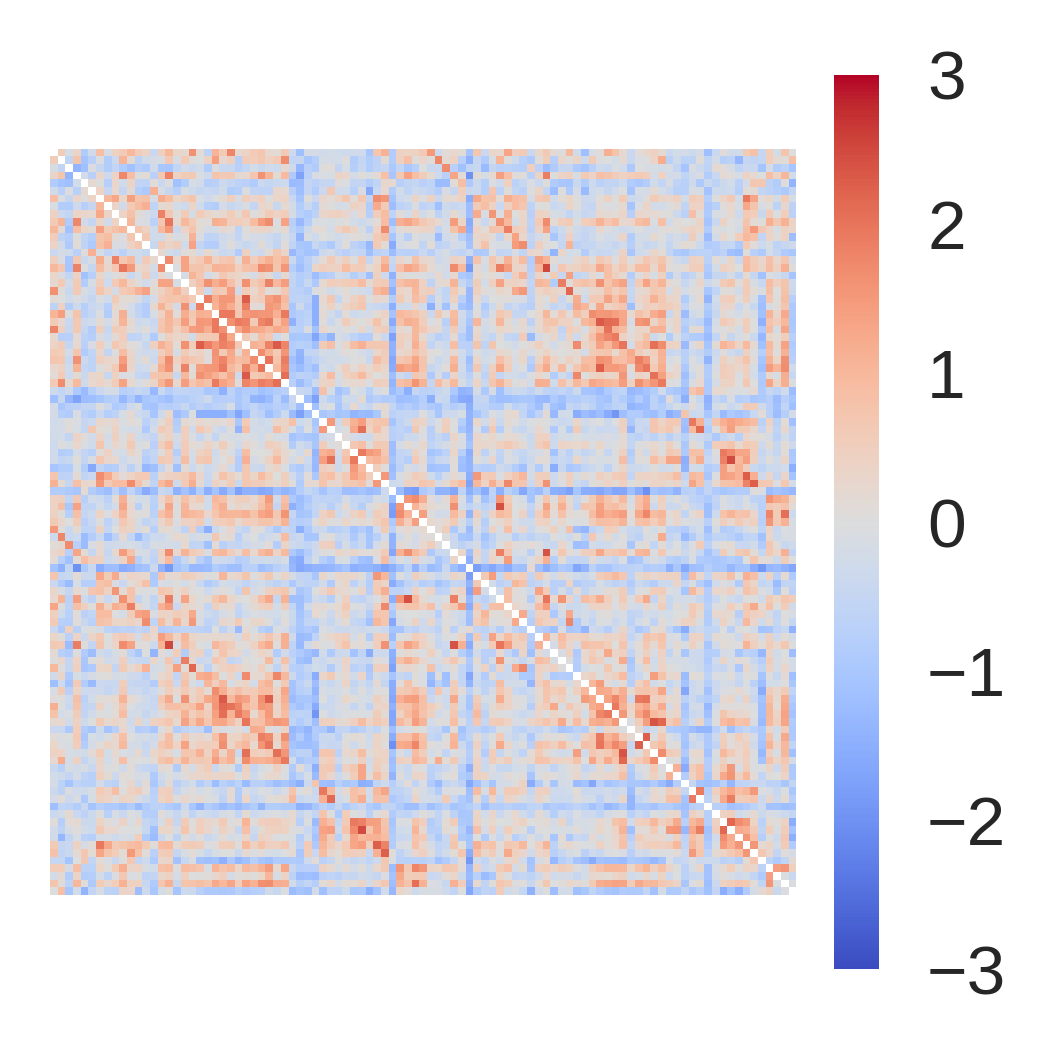

In [ ]:
def recon_matrix(X):
  X1=np.zeros((97,97))
  X1[np.triu_indices(97,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,np.nan)
  return X1
fig = plt.figure(figsize=(2,2),dpi= 500,constrained_layout=True)
sns.heatmap(recon_matrix(area_to_func[0]),cbar=True,cmap="coolwarm",annot=False,square=True,xticklabels=False,yticklabels=False,vmin=-3,vmax=3)


## Recon fMRI

In [ ]:
def recon_matrix(X):
  X1=np.zeros((97,97))
  X1[np.triu_indices(97,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,np.nan)
  return X1
fig = plt.figure(figsize=(12,12), dpi= 300,constrained_layout=True)


ax = fig.add_subplot(3,3, 1)
sns.heatmap(recon_matrix(np.mean(model_func.decode(func_latent_ful).detach().numpy()-func_data,0)),ax=ax,cmap="coolwarm",annot=False,square=True,xticklabels=False,yticklabels=False)

ax.set_title("Functional Connectivity (Full Sample)")

ax = fig.add_subplot(3,3, 2, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_area.decode(area_latent_ful).detach().numpy()-thick_data,0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Thickness (Full Sample)")
ax = fig.add_subplot(3,3, 3, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_thick.decode(thick_latent_ful).detach().numpy()-area_data,0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Surface Area (Full Sample)")

ax = fig.add_subplot(3,3, 4)
sns.heatmap(recon_matrix(np.mean(model_func.decode(func_latent_ful[np.where(pheno2.iloc[:,0]==1)]).detach().numpy()-func_data[np.where(pheno2.iloc[:,0]==1)],0)),ax=ax,cmap="coolwarm",annot=False,square=True,xticklabels=False,yticklabels=False)

ax.set_title("Functional Connectivity (ASD)")

ax = fig.add_subplot(3,3, 5, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_area.decode(area_latent_ful[np.where(pheno2.iloc[:,0]==1)]).detach().numpy()-thick_data[np.where(pheno2.iloc[:,0]==1)],0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Thickness (ASD)")
ax = fig.add_subplot(3,3, 6, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_thick.decode(thick_latent_ful[np.where(pheno2.iloc[:,0]==1)]).detach().numpy()-area_data[np.where(pheno2.iloc[:,0]==1)],0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Surface Area (ASD)")


ax = fig.add_subplot(3,3, 7)
sns.heatmap(recon_matrix(np.mean(model_func.decode(func_latent_ful[np.where(pheno2.iloc[:,0]==2)]).detach().numpy()-func_data[np.where(pheno2.iloc[:,0]==2)],0)),ax=ax,cmap="coolwarm",annot=False,square=True,xticklabels=False,yticklabels=False)

ax.set_title("Functional Connectivity (Typical Control)")

ax = fig.add_subplot(3,3, 8, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_area.decode(area_latent_ful[np.where(pheno2.iloc[:,0]==2)]).detach().numpy()-thick_data[np.where(pheno2.iloc[:,0]==2)],0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Thickness (Typical Control)")
ax = fig.add_subplot(3,3, 9, projection='3d')

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_thick.decode(thick_latent_ful[np.where(pheno2.iloc[:,0]==2)]).detach().numpy()-area_data[np.where(pheno2.iloc[:,0]==2)],0),axes=ax,colorbar=True,cmap='coolwarm')
ax.set_title("Cortical Surface Area (Typical Control)")




In [ ]:
fig = plt.figure(constrained_layout=True)


ax = fig.add_subplot(111,projection='3D')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,np.mean(model_area.decode(area_latent_ful[np.where(pheno2.iloc[:,0]==2)]).detach().numpy()-thick_data[np.where(pheno2.iloc[:,0]==2)],0),axes=ax,colorbar=True,cmap='coolwarm')

In [ ]:
def recon_matrix(X):
  X1=np.zeros((97,97))
  X1[np.triu_indices(97,k=1)]=X
  X1 = X1 + X1.T - np.diag(np.diag(X1))
  np.fill_diagonal(X1,np.nan)
  return X1

fig, ax = plt.subplots(2,4, figsize=(16,7),dpi=300, constrained_layout=True)
input=func_data
reconby=func_latent_ful
reconby1=area_latent_ful
reconby2=thick_latent_ful


sns.heatmap(recon_matrix(np.mean(input-np.mean(input,0),0)),cmap="coolwarm",ax=ax[0,0])

sns.heatmap(recon_matrix(np.std(input-np.mean(input,0),0)),cmap="coolwarm",ax=ax[1,0])

sns.heatmap(recon_matrix(np.mean(model_func.decode(reconby).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[0,1])

sns.heatmap(recon_matrix(np.std(model_func.decode(reconby).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[1,1],vmax=1)

sns.heatmap(recon_matrix(np.mean(model_func.decode(reconby1).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[0,2])
sns.heatmap(recon_matrix(np.std(model_func.decode(reconby1).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[1,2],vmax=1)


sns.heatmap(recon_matrix(np.mean(model_func.decode(reconby2).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[0,3])
sns.heatmap(recon_matrix(np.std(model_func.decode(reconby2).detach().numpy()-input,0)),cmap="coolwarm",ax=ax[1,3],vmax=1)


# Brain Crossmodal Reconstruction Visualizations

In [ ]:
fsaverage=datasets.fetch_surf_fsaverage(mesh='fsaverage')

In [ ]:

area_data=np.load('/content/drive/My Drive/BA/full_data_thick.npy')[:,:,0].T
area_data=(area_data - np.mean(area_data)) / np.std(area_data)
#Cortical Thickness Data
thick_data=np.load('/content/drive/My Drive/BA/full_data_area.npy')[:,:,0].T
thick_data=(thick_data - np.mean(thick_data)) / np.std(thick_data)


In [ ]:
fig = plt.figure(dpi= 100,constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot=plotting.plot_surf_stat_map(
          fsaverage.pial_left, thick_data[0], colorbar=False,axes=ax,cmap="Blues", bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=0.5)
plot.figure.savefig('/content/drive/My Drive/BA/thickness.png')

In [ ]:
savefig('/content/drive/My Drive/BA/demo2.png', transparent=False)

In [ ]:
def plot_brain(data,plot_n):
  ax = fig.add_subplot(2, 2, plot_n*4+1, projection='3d')
  plotting.plot_surf_stat_map(
          fsaverage.infl_left, upscale(data)[len(data):], hemi='left', colorbar=False,axes=ax,cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=.3)
  ax = fig.add_subplot(2, 2, plot_n*4+2, projection='3d')
  plotting.plot_surf_stat_map(
        fsaverage.infl_left, upscale(data)[len(data):], hemi='left', colorbar=False ,axes=ax,cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,view='medial')
  ax = fig.add_subplot(2, 2, plot_n*4+3, projection='3d')
  plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(data)[:len(data)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax)
  ax = fig.add_subplot(2, 2, plot_n*4+4, projection='3d')
  plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(data)[:len(data)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax,view='medial')


fig = plt.figure(dpi= 300)

for i, data  in enumerate([area_data[0]]):
  plot_brain(data,i)


plt.subplots_adjust(wspace=0, hspace=0)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax)


In [ ]:

fig, axes = plt.subplots(2,2,figsize=(6,6),subplot_kw=dict(projection='3d'))
ax = axes.ravel()




im=plotting.plot_surf_stat_map(
          fsaverage.infl_left, upscale(func_to_thick[0])[len(data):], hemi='left', colorbar=False,axes=ax[0],cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=.3,vmin=-3,vmax=3)
im=plotting.plot_surf_stat_map(
      fsaverage.infl_left, upscale(func_to_thick[0])[len(data):], hemi='left', colorbar=False ,axes=ax[1],cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,view='medial',vmin=-3,vmax=3)
im=plotting.plot_surf_stat_map(
      fsaverage.infl_right, upscale(func_to_thick[0])[:len(data)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax[2],vmin=-3,vmax=3)
im=plotting.plot_surf_stat_map(
      fsaverage.infl_right, upscale(func_to_thick[0])[:len(data)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax[3],view='medial',vmin=-3,vmax=3)


plt.subplots_adjust(wspace=0, hspace=0)


plt.show()

In [ ]:
fig = plt.figure(figsize=(3,6),dpi= 300,constrained_layout=True)

for i, data  in enumerate([thick_data_mean,thick_recon]):
  plot_brain(data,i)


In [ ]:
fig = plt.figure(figsize=(3,6),dpi= 300,constrained_layout=True)
for i in range (8):
ax = fig.add_subplot(2, 4, 1, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_left, upscale(area_data_mean)[len(area_data_mean):], hemi='left', colorbar=False,axes=ax,cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,darkness=.3)


ax = fig.add_subplot(2, 4, 2, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_left, upscale(area_data_mean)[len(area_data_mean):], hemi='left', colorbar=True ,axes=ax,cmap="coolwarm", bg_map=fsaverage['sulc_left'], bg_on_data=True,view='medial')

ax = fig.add_subplot(2, 4, 3, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(area_data_mean)[:len(area_data_mean)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax)
ax = fig.add_subplot(2, 4, 4, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(area_data_mean)[:len(area_data_mean)], hemi='right', colorbar=True, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax,view='medial')

ax = fig.add_subplot(2, 4, 5, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_left, upscale(area_recon)[len(area_recon):], hemi='left', colorbar=False, bg_map=fsaverage['sulc_left'], bg_on_data=True,cmap="coolwarm",axes=ax)
ax = fig.add_subplot(2, 4, 6, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_left, upscale(area_recon)[len(area_recon):], hemi='left', colorbar=True, bg_map=fsaverage['sulc_left'], bg_on_data=True,cmap="coolwarm",axes=ax,view='medial')

ax =fig.add_subplot(2, 4, 7, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(area_recon)[:len(area_recon)], hemi='right', colorbar=False, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax)
ax = fig.add_subplot(2, 4, 8, projection='3d')
plotting.plot_surf_stat_map(
        fsaverage.infl_right, upscale(area_recon)[:len(area_recon)], hemi='right', colorbar=True, bg_map=fsaverage['sulc_right'], bg_on_data=True,cmap="coolwarm",axes=ax,view='medial')

In [ ]:

fig = plt.figure(figsize=(12,6), dpi= 300,constrained_layout=True)

for i,data in enumerate([area_data_mean,area_recon,func_to_area,thick_to_area,thick_data_mean,thick_recon,func_to_thick,area_to_thick]):
  ax = fig.add_subplot(2, 4, i+1, projection='3d')
  plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,upscale(data)[len(data):],axes=ax,colorbar=True,cmap='viridis')
'''
ax.set_title("Average Normalized CSA")

ax = fig.add_subplot(2, 4, 2, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,thick_recon.flatten(),axes=ax,colorbar=True,cmap='viridis')
ax.set_title("Average Reconstructed CSA")

ax = fig.add_subplot(2, 4, 3, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,func_to_thick,axes=ax,colorbar=True,cmap='viridis')
ax.set_title("Average FC -> CSA")

ax = fig.add_subplot(2, 4, 4, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,area_to_thick,axes=ax,colorbar=True,cmap='viridis')

ax.set_title("Average CT -> CSA")

ax = fig.add_subplot(2, 4, 5, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,thick_data_mean,axes=ax,colorbar=True,cmap='winter')
ax.set_title("Average Normalized CT")


ax = fig.add_subplot(2, 4, 6, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,area_recon,axes=ax,colorbar=True,cmap='winter')
ax.set_title("Average Reconstructed CT")
ax = fig.add_subplot(2, 4, 7, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,func_to_area,axes=ax,colorbar=True,cmap='winter')
ax.set_title("Average FC -> CT")

ax = fig.add_subplot(2, 4, 8, projection='3d')
plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').white_left,thick_to_area,axes=ax,colorbar=True,cmap='winter')
ax.set_title("Average CSA -> CT")'''

In [ ]:
from nilearn import surface
texture = surface.vol_to_surf(upscale(data), datasets.fetch_surf_fsaverage(mesh='fsaverage').pial_right)

In [ ]:
import plotly

plotting.plot_surf_stat_map(datasets.fetch_surf_fsaverage(mesh='fsaverage').pial_left,upscale(data)[:len(data)],
                          views=['anterior'],
                          hemispheres=['left'],
                          colorbar=True)
plotting.show()



In [ ]:

stat_img = datasets.load_sample_motor_activation_image()
print(stat_img)